In [12]:
#Import the packages required for the job.
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [13]:
#from keras.datasets import imdb
#Loading IMDB standard dataset using the Keras dataset class.
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                         split=['train', 'test'],  # + 'unsupervised'
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

print(ds_info.features)

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})


In [14]:
# pre-processing the dataset
X_train = []
y_train = []

X_test_str = []
y_test = []
# Extract training data and store it in the list
for sentense, label in ds_train:
    X_train.append(sentense.numpy().decode('utf8'))
    y_train.append(label.numpy())
# Extract test data and store it in the list
for sentense, label in ds_test:
    X_test_str.append(sentense.numpy().decode('utf8'))  # X_test_str is used at the test stage
    y_test.append(label.numpy())
# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
# print the sample data, X_train[0]
print(X_train[0])
print('The review is', 'Positive' if y_train[0]==1 else 'Negative')

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
The review is Negative


In [16]:
#Tokenizer and Integer encoding
# hyperparameter for word embeddings
vocab_size = 10000
embedding_size = 128
max_length = 300

### START CODE HERE ###
# Create Tokenizer objects and train them to X_train data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
# Gets a unique index for each word
word_index = tokenizer.word_index
# Converting sentences into word index sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test_str)
# Padding the sequence to its maximum length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length)
X_test  = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length)

### END CODE HERE ###


In [ ]:
# This cell uses the GRU model.
# Import the packages required for the job.
from keras.layers import Embedding, Bidirectional, Dense
import tensorflow as tf

hidden_states = 64
dropout_rate = 0.5

model = tf.keras.Sequential()
# Embedded layer: transforming words into embedded vectors
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length)) # embedding layer
# Bidirectional GRU layer: Bidirectional recurrent neural networks
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hidden_states)))  # bidirectional GRU
# Dropout layer: Apply dropout to prevent overfitting
model.add(tf.keras.layers.Dropout(dropout_rate))  # dropout
# Output layer: Using the sigmoid activation function for binary classification
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # output layer
# Compilation of models: setting loss functions, optimizers, and evaluation metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Model Summary Output
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1354625 (5.17 MB)
Trainable params: 1354625 (5.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# This cell uses the LSTM model.
# Import the packages required for the job.
from keras.layers import Embedding, Bidirectional, Dense
import tensorflow as tf

hidden_states = 64
dropout_rate = 0.5

model = tf.keras.Sequential()
# Embedded layer: transforming words into embedded vectors
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length)) # embedding layer
# Bidirectional LSTM layer: Bidirectional recurrent neural networks
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_states)))  # bidirectional GRU
# Dropout layer: Apply dropout to prevent overfitting
model.add(tf.keras.layers.Dropout(dropout_rate))  # dropout
# Output layer: Using the sigmoid activation function for binary classification
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # output layer
# Compilation of models: setting loss functions, optimizers, and evaluation metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Model Summary Output
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Training
n_batch = 64
# Early termination callback: Monitoring verification loss, minimization mode, shutdown if not improved during 4 epoch
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# Model Checkpoint Callback: Save Model with Highest Verification Accuracy
mc = tf.keras.callbacks.ModelCheckpoint('GRU_imdb.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Model training
results = model.fit(X_train, y_train,
            batch_size=n_batch,
            epochs=10,
            callbacks=[es, mc],
            validation_split=0.2)
# Outputting Training Results
print(results.history['loss'])
print(results.history['accuracy'])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.7886
Epoch 1: val_accuracy improved from -inf to 0.85200, saving model to GRU_imdb.h5
313/313 [==============================] - 39s 111ms/step - loss: 0.4478 - accuracy: 0.7886 - val_loss: 0.3454 - val_accuracy: 0.8520
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9007
Epoch 2: val_accuracy improved from 0.85200 to 0.87780, saving model to GRU_imdb.h5
313/313 [==============================] - 19s 59ms/step - loss: 0.2618 - accuracy: 0.9007 - val_loss: 0.3088 - val_accuracy: 0.8778
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9104
Epoch 3: val_accuracy did not improve from 0.87780
313/313 [==============================] - 13s 43ms/step - loss: 0.2332 - accuracy: 0.9104 - val_loss: 0.3730 - val_accuracy: 0.8506
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9409
Epoch 4: val_accuracy did not improve from 0.87780
313/313 [==============================] - 11s 35ms/step - loss: 0.1603 - accuracy: 0.9409 - val_loss: 0.3563 - val_accuracy: 0.8716
Epoch 5/10
313/313 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9506
Epoch 5: val_accuracy did not improve from

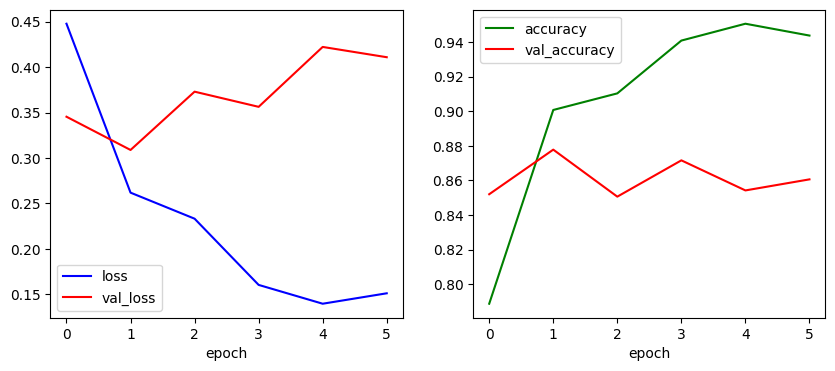

In [19]:
# plot loss and accuracy
import matplotlib.pyplot as plt
# Create graph objects to draw loss and accuracy graphs
plt.figure(figsize=(10,4))
# First subplot: Loss Graph
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()
# Second subplot: Accuracy Graph
plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], 'g-', label='accuracy')
plt.plot(results.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()
# print the graph
plt.show()

In [20]:
# model = tf.keras.models.load_model('GRU_imdb.h5')
model.evaluate(X_test, y_test)

782/782 [==============================] - 12s 16ms/step - loss: 0.4251 - accuracy: 0.8580


[0.4250820279121399, 0.8579599857330322]

In [21]:
# select the random index
idx = np.random.randint(X_test.shape[0])
# Reshaping the selected test data to enter the model
X_input = X_test[idx].reshape(1,-1)
# Use the model to predict the positivity score of the selected review
score = float(model.predict(X_input))
# Decide positively or negatively for reviews based on predicted scores
decision = 1 if score>0.5 else 0
# Use the score if positive and subtract the score from 1 if negative to calculate the opposite score
rate = score if decision==1 else (1-score)
# print the selected review text
print(X_test_str[idx])
# print the decision and score
print('The review is', 'Positive' if decision==1 else 'Negative', 'in {:.2f}% '.format(rate*100))

#print(X_input.shape)

1/1 [==============================] - 1s 669ms/step
When the movie first started I thought cheesy. The first ten minutes were really boring. After the slow beginning and some of the soap opera antics, I started liking it. The plot was different than anything I had ever seen. Now, was it a horror? Not really. It shouldn't have been classied as a horror or the producers should have put more money into the movie to make it scary. As it was, the creatures where only there for a short time. I can only assume this was for money reason.<br /><br />The good side was that the movie was very entertaining. It held my interest (after the start) and did make me wonder about creatures from another dimension.<br /><br />It was obvious that this was a first time movie for the director, but there were a couple of highlights. By the end, I was hooked. Too bad Hollywood didn't put more money behind this.
The review is Negative in 99.27% 
